In [6]:
import sys
sys.path.append('/home/tigranfahradyan/ChemLacticaTestSuit/ChemLacticaTestSuite/utils/')


In [7]:
from prompt_checker import get_start2end_tags_map, check_syntax


ModuleNotFoundError: No module named 'prompt_checker'

In [2]:
import os
import re
import numpy as np
import pandas as pd
import textwrap
import pickle
import torch
from accelerate import init_empty_weights, Accelerator
from transformers import AutoModelForCausalLM, AutoTokenizer
from custom_modeling_opt import CustomOPTForCausalLM
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from torch.nn.utils.rnn import pad_sequence

import multiprocessing


In [3]:
seed_value=42
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
import rdkit.Chem as Chem
import sys
from rdkit.Chem import RDConfig, MACCSkeys, QED
from rdkit.Chem.rdMolDescriptors import CalcTPSA, CalcCrippenDescriptors
from rdkit.Chem import Descriptors
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

In [5]:
device = "cuda:1"

In [6]:
tokenizer = AutoTokenizer.from_pretrained("/home/menuab/code/ChemLacticaTestSuite/src/tokenizer/ChemLacticaTokenizer_50066/")
print('tokenizer size: ', len(tokenizer))

tokenizer size:  50066


In [145]:
checkpoint_path = "/home/menuab/code/checkpoints/f2c6ebb289994595a478f513/125m_126k_f2c6/"
checkpoint_path = "/home/menuab/code/checkpoints/f3fbd012918247a388efa732/125m_126k_f3fb/"
# checkpoint_path = "/home/menuab/code/checkpoints/90758da0b8564bae8a14bbef/125m_63k_9075/"
checkpoint_path

'/home/menuab/code/checkpoints/f3fbd012918247a388efa732/125m_126k_f3fb/'

In [146]:
model = CustomOPTForCausalLM.from_pretrained(
            checkpoint_path,
            use_flash_attn=True,
            torch_dtype=torch.bfloat16
            )
model.eval()
model.to(device)
print(f'model loaded with embedding size of : {model.model.decoder.embed_tokens.num_embeddings}')
assert(model.model.decoder.embed_tokens.num_embeddings == len(tokenizer))

model loaded with embedding size of : 50066


In [8]:
# moses = pd.read_csv('./data/dataset_v1.csv')
# moses.head()

In [9]:
# moses = moses[moses.SPLIT == 'train']
# moses.head()

In [10]:
# moses[['SAS', 'QED', 'CLOGP', 'WEIGHT']] = 0

In [11]:
# moses.head()

In [9]:

# Define the worker function
def process_molecule(mol):
    print(mol)
    mol_source = Chem.MolFromSmiles(mol)
    sas_score = sascorer.calculateScore(mol_source) 
    qed_score = round(QED.qed(mol_source), 3)
    clogp_score = round(Descriptors.MolLogP(mol_source), 3)
    weight_score = round(Descriptors.ExactMolWt(mol_source), 3)
    return sas_score, qed_score, clogp_score, weight_score

# Main function to use multiprocessing
def process_many_molecules(df):
    # Create a pool of workers
    with multiprocessing.Pool(20) as pool:
        # Process the molecules using the pool
        results = list(tqdm(pool.imap(process_molecule, df.iloc[:,0]), total=len(df)))

    # Store the results back into the DataFrame
    for en, (sas_score, qed_score, clogp_score, weight_score) in enumerate(results):
        df.iloc[en, 2] = sas_score
        df.iloc[en, 3] = qed_score
        df.iloc[en, 4] = clogp_score
        df.iloc[en, 5] = weight_score



In [24]:
# process_many_molecules(moses)

In [14]:
# moses.to_csv('moses_train_properties.csv')

In [84]:
moses = pd.read_csv('moses_train_properties.csv')

In [16]:
moses.head(5)

,Unnamed: 0,SMILES,SPLIT,SAS,QED,CLOGP,WEIGHT
0,0,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,train,3.812618,0.897,1.681,281.083
1,1,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1,train,2.936327,0.862,3.729,292.098
2,3,Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO,train,2.663795,0.701,2.297,336.088
3,4,Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C,train,2.989161,0.646,-2.213,254.102
4,5,CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O,train,3.055750,0.853,0.807,271.061


In [17]:
batch_size = 64

# Initialize lists to store results
targets1, targets2, targets3, targets4 = [], [], [], []
sas_scores, clogp_scores, qed_scores, weight_scores = [], [], [], []
sac_invalids, mols = [], []

# Process in batches
for batch_start in tqdm(range(0, min(1280, len(moses)), batch_size)):
    batch_end = min(batch_start + batch_size, len(moses))
    inputs_batch = []

    for i in range(batch_start, batch_end):
        _, mol, split, sas, qed, clogp, weight = moses.iloc[i, :] # one more column in CSV
        prompt = f"</s>[SAS]{sas:.2f}[/SAS][CLOGP]{clogp:.2f}[/CLOGP][QED]{qed:.2f}[/QED][WEIGHT]{weight:.2f}[/WEIGHT]"
        inputs = tokenizer(prompt, return_tensors="pt").input_ids
        inputs = inputs.to(device)
        # print(inputs.shape, prompt)
        inputs_batch.append(inputs.squeeze(0))  # Remove the extra dimension

    min_length = min([len(i) for i in inputs_batch])

    inputs_batch = torch.stack([i[:min_length] for i in inputs_batch])  # Cutting the last tokens of long sequences
    # print(torch.stack(inputs_batch))

    # Generate outputs for the entire batch
    out = model.generate(inputs_batch, max_new_tokens=600, do_sample=False, eos_token_id=20, return_dict_in_generate=True, output_scores=True)

    # Process outputs for each sequence in the batch
    for seq in out.sequences:
        decoded = tokenizer.decode(seq)
        # print(decoded)
        try:
            if "[END_SMILES]" not in decoded:
                continue
            captured_text = decoded[decoded.find("[START_SMILES]")+len("[START_SMILES]"):decoded.find("[END_SMILES]")]
            mols.append(captured_text)
        except:
            continue


  0%|          | 0/20 [00:00<?, ?it/s]

In [18]:
len(mols)

856

In [30]:
generated = pd.DataFrame(mols, columns=['SMILES'])

In [31]:
generated[['split', 'SAS', 'QED', 'CLOGP', 'WEIGHT']] = 0

In [32]:
generated.head(10)

,SMILES,split,SAS,QED,CLOGP,WEIGHT
0,CC1=C(C=CC(=C1)C2=NN(C(=O)C2)C3CCS(=O)(=O)C3)O,0,0,0,0,0
1,CC1=CC(=C(C=C1)C)C(C)NC(=O)C2=CC(=C(C=C2)F)Cl,0,0,0,0,0
2,CC1=C(C=CC(=C1)OCC(=O)OCC2=NC(=NO2)C(C)C)O,0,0,0,0,0
3,CC(C)(C)OC(=O)NCC(=O)NCC1=CC(=O)NN1,0,0,0,0,0
4,CC(C)(C)NS(=O)(=O)C1=CC(=C(C=C1)F)C(=O)N,0,0,0,0,0
5,CC1=CC(=C(C=C1)C)C(C)NC(=O)C2=C(N=CC=C2)OC,0,0,0,0,0
6,CC1=C(C=CC(=C1)Br)NC(=O)C(C)SC2=NN=C(S2)C,0,0,0,0,0
7,CC(C)(C)OC(=O)NCC(C1=CC(=CC=C1)Br)OC,0,0,0,0,0
8,CC(C)(C)OC(=O)NC(CC1=CC=CC=C1)C(=O)O,0,0,0,0,0
9,CC1=CC(=C(C=C1)C)N2C(=O)C(N(C2=O)C)CC(=O)O,0,0,0,0,0


In [ ]:
process_many_molecules(generated)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/856 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
CC1=CC(=C(C=C1)C)C(C)NC(=O)C2=C(N=CC=C2)OCCC(C)(C)OC(=O)NC(CC1=CC=CC=C1)C(=O)OCC(C)(C)NS(=O)(=O)C1=CC(=C(C=C1)F)C(=O)NCC(C)(C)OC(=O)NCC(C1=CC(=CC=C1)Br)OCCC1=C(C=C(C=C1)C(C)NC(=O)C2=C(N=CC(=C2)C)OC)ClCC1=C(C=CC(=C1)C(=O)C(C)SC2=NNC(=N2)C)Fhuggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
CC1=CC(=C(C=C1)C(=O)N2CC(C(C2)O)C(=O)OC)FCC1=CC(=C(C=C1)C)N2C(=O)C(N(C2=O)C)CC(=O)OCC1=CC=CC=C1NC(=O)C2=CC=CC=C2N

In [ ]:
generated.head(10)

In [ ]:
plt.hist(sas_scores, range=(0,8), bins=50, alpha=.5, density=True);
plt.hist(targets1, range=(0,8), bins=50, alpha=.5, density=True);

In [ ]:
plt.hist(clogp_scores, range=(-2,10), bins=50, alpha=.5, density=True);
plt.hist(targets2, range=(-2,10), bins=50, alpha=.5, density=True);

In [ ]:
plt.hist(qed_scores, range=(0,1), bins=50, alpha=.5, density=True);
plt.hist(targets3, range=(0,1), bins=50, alpha=.5, density=True);

In [ ]:
plt.hist(weight_scores, range=(100,500), bins=100, alpha=.5, density=True);
plt.hist(targets4, range=(100,500), bins=100, alpha=.5, density=True);

In [ ]:
(np.array(targets4) < 250).sum()

# For Slides

In [36]:
clogp = 1.31

prompt = f"</s>[CLOGP]{clogp:.2f}[/CLOGP][START_SMILES]"
inputs = tokenizer(prompt, return_tensors="pt").input_ids
inputs = inputs.to(device)
# print(inputs.shape, prompt)

# Generate outputs for the entire batch
# out = model.generate(inputs, max_new_tokens=600, do_sample=False, eos_token_id=20, return_dict_in_generate=True, output_scores=True)
out = model.generate(inputs, max_new_tokens=300, do_sample=False,
                            num_return_sequences=6, num_beams=6, length_penalty=-9, renormalize_logits=True,
                            repetition_penalty=1.0, diversity_penalty=1., num_beam_groups=3, 
                            eos_token_id=20, return_dict_in_generate=True, output_scores=True)

# Process outputs for each sequence in the batch
for seq in out.sequences:
    decoded = tokenizer.decode(seq)
    print(decoded)
    captured_text = decoded[decoded.find("[START_SMILES]")+len("[START_SMILES]"):decoded.find("[END_SMILES]")]
    sas, qed, clogp, weight = process_molecule(captured_text)
    print(f'{clogp:.2f} \n\n')

</s>[CLOGP]1.31[/CLOGP][START_SMILES]COC1=CC=CC=C1NC(=O)CN2CCN(CC2)C(=O)C3=CC=CC=C3[END_SMILES]<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [34]:
clogp

35.589

In [40]:
mol = Chem.MolFromSmiles('COC1=CC=CC=C1NC(=O)CN2CCN(CC2)C(=O)C3=CC=CC=C3')

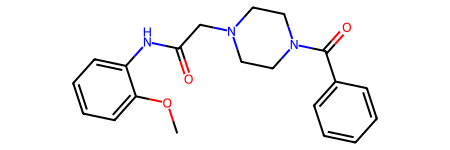

In [41]:
mol

In [46]:
def tanimoto_similarity(smiles_1, smiles_2):
    fgp1 = np.array(MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(smiles_1)))
    fgp2 = np.array(MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(smiles_2)))

    both = np.sum(fgp1 & fgp2)

    return both / (np.sum(fgp1) + np.sum(fgp2) - both)

In [72]:
clogp = 3.42
similarity_score = 0.82
seed = 'C1=CC=C(C=C1)C2=NC(=CC3=CC=C(C=C3)[N+](=O)[O-])C(=O)O2'

prompt = f"</s>[SIMILAR]{seed} {similarity_score:.2f}[/SIMILAR][START_SMILES]"
# prompt = f"</s>[CLOGP]{clogp:.2f}[/CLOGP][SIMILAR]{similarity_score:.2f} {seed}[/SIMILAR][START_SMILES]"
# print(prompt)
inputs = tokenizer(prompt, return_tensors="pt").input_ids
inputs = inputs.to(device)
# print(inputs.shape, prompt)

# Generate outputs for the entire batch
# out = model.generate(inputs, max_new_tokens=600, do_sample=False, eos_token_id=20, return_dict_in_generate=True, output_scores=True)
out = model.generate(inputs, max_new_tokens=300, do_sample=False,
                            num_return_sequences=6, num_beams=6, length_penalty=-9, renormalize_logits=True,
                            repetition_penalty=1.0, diversity_penalty=1., num_beam_groups=3, 
                            eos_token_id=20, return_dict_in_generate=True, output_scores=True)

# Process outputs for each sequence in the batch
for seq in out.sequences:
    decoded = tokenizer.decode(seq)
    # print(decoded)
    captured_text = decoded[decoded.find("[START_SMILES]")+len("[START_SMILES]"):decoded.find("[END_SMILES]")]
    sas, qed, clogp, weight = process_molecule(captured_text)
    # print(captured_text)
    sim = tanimoto_similarity(seed, captured_text)
    print(f'Actual CLogP = {clogp:.2f}, actual similarity = {sim:.2f} \n\n')

CCCC1=NC(=CC2=CC=C(C=C2)[N+](=O)[O-])C(=O)O1
Actual CLogP = 2.69, actual similarity = 0.81 


C1=CC=C(C=C1)C2=NC(=CC3=CC=C(C=C3)[N+](=O)[O-])C(=O)O2
Actual CLogP = 2.94, actual similarity = 1.00 


CC1=CC=C(C=C1)C2=NC(=CC3=CC=C(C=C3)[N+](=O)[O-])C(=O)O2
Actual CLogP = 3.25, actual similarity = 0.98 


C1=CC=C2C(=C1)C(=CC(=N2)C3=CC(=CC=C3)[N+](=O)[O-])C(=O)O
Actual CLogP = 3.51, actual similarity = 0.62 


C1=CC(=CC=C1/C=C\2/C(=O)OC(=N2)C3=CC=C(C=C3)[N+](=O)[O-])[N+](=O)[O-]
Actual CLogP = 2.85, actual similarity = 1.00 


C1=CC(=CC=C1/C=C/2\C(=O)OC(=N2)C3=CC=C(C=C3)[N+](=O)[O-])[N+](=O)[O-]
Actual CLogP = 2.85, actual similarity = 1.00 




In [197]:
targets = []
generated = []
mol_count = 10
values = np.arange(0.51, 1.00, 0.04)

In [2]:
start2end = get_start2end_tags_map("/home/menuab/code/ChemLacticaTestSuite/src/tokenizer/ChemLacticaTokenizer_50066/")
        

for similarity_score in tqdm(values):
    for i in range(mol_count):
        seed = moses['SMILES'][i * 40]
        prompt = f"[SIMILAR]{seed} {similarity_score:.2f}[/SIMILAR][START_SMILES]"

        check_syntax(prompt, start2end)
        
        inputs = tokenizer(prompt, return_tensors="pt").input_ids
        inputs = inputs.to(device)
        # print(inputs.shape, prompt)
        
        # Generate outputs for the entire batch
        # out = model.generate(inputs, max_new_tokens=600, do_sample=False, eos_token_id=20, return_dict_in_generate=True, output_scores=True)
        out = model.generate(inputs, max_new_tokens=300, do_sample=False,
                                    num_return_sequences=6, num_beams=6, length_penalty=-9, renormalize_logits=True,
                                    repetition_penalty=1.0, diversity_penalty=1., num_beam_groups=3, 
                                    eos_token_id=20, return_dict_in_generate=True, output_scores=True)

        # Process outputs for each sequence in the batch
        for seq in out.sequences:
            decoded = tokenizer.decode(seq)
            # print(decoded)
            captured_text = decoded[decoded.find("[START_SMILES]")+len("[START_SMILES]"):decoded.find("[END_SMILES]")]
            # sas, qed, clogp, weight = process_molecule(captured_text)
            # print(captured_text)
            try:
                sim = tanimoto_similarity(seed, captured_text)
                targets.append(similarity_score)
                generated.append(sim)
            except:
                print("Something is invalid:", captured_text)
            # print(f'Actual CLogP = {clogp:.2f}, actual similarity = {sim:.2f} \n\n')

NameError: name 'get_start2end_tags_map' is not defined

In [210]:
len(generated), mol_count * len(values) * 6

(1318, 780)

In [211]:
metrics.mean_squared_error(targets, generated, squared=False), spearmanr(targets, generated).statistic

(0.4832813912619703, -0.08471468815914374)

Text(0, 0.5, 'Generated similarity')

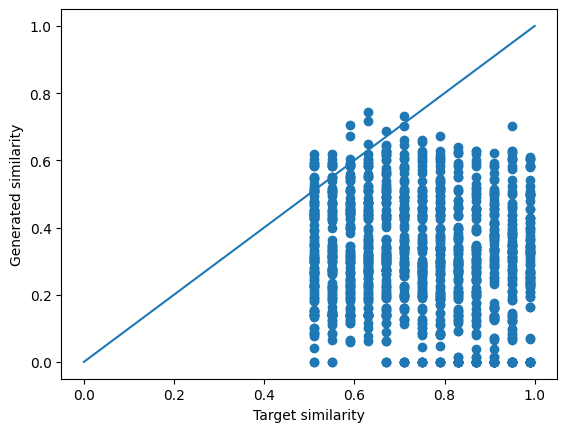

In [212]:
plt.figure()
plt.scatter(targets, generated)
plt.plot([0,1], [0,1])
plt.xlabel("Target similarity")
plt.ylabel("Generated similarity")

### Similarity calculation

In [83]:

seed = 'C1=CC=C(C=C1)C2=NC(=CC3=CC=C(C=C3)[N+](=O)[O-])C(=O)O2'
molecule = 'C1=CC=C2C(=C1)C(=CC(=N2)C3=CC(=CC=C3)[N+](=O)[O-])C(=O)O'
truth = tanimoto_similarity(seed, molecule)

prompt = f"</s>[START_SMILES]{molecule}[END_SMILES][SIMILAR]{seed} "
print(prompt + '\n')
inputs = tokenizer(prompt, return_tensors="pt").input_ids
inputs = inputs.to(device)
# print(inputs.shape, prompt)

# Generate outputs for the entire batch
# out = model.generate(inputs, max_new_tokens=600, do_sample=False, eos_token_id=20, return_dict_in_generate=True, output_scores=True)
out = model.generate(inputs, max_new_tokens=20, do_sample=False,
                            num_return_sequences=6, num_beams=6, length_penalty=-9, renormalize_logits=True,
                            repetition_penalty=1.0, diversity_penalty=1., num_beam_groups=3, 
                            eos_token_id=20, return_dict_in_generate=True, output_scores=True)
for seq in out.sequences:
    decoded = tokenizer.decode(seq)
    print(decoded)
    predicted = float(decoded[len(prompt):decoded.find('[/SIMILAR]')].strip())
    print(f'{predicted}\n')


0.625
</s>[START_SMILES]C1=CC=C2C(=C1)C(=CC(=N2)C3=CC(=CC=C3)[N+](=O)[O-])C(=O)O[END_SMILES][SIMILAR]C1=CC=C(C=C1)C2=NC(=CC3=CC=C(C=C3)[N+](=O)[O-])C(=O)O2 

</s>[START_SMILES]C1=CC=C2C(=C1)C(=CC(=N2)C3=CC(=CC=C3)[N+](=O)[O-])C(=O)O[END_SMILES][SIMILAR]C1=CC=C(C=C1)C2=NC(=CC3=CC=C(C=C3)[N+](=O)[O-])C(=O)O2 0.78[/SIMILAR][SIMILAR]C1=CC=C(C=C1)C2
0.78
 
</s>[START_SMILES]C1=CC=C2C(=C1)C(=CC(=N2)C3=CC(=CC=C3)[N+](=O)[O-])C(=O)O[END_SMILES][SIMILAR]C1=CC=C(C=C1)C2=NC(=CC3=CC=C(C=C3)[N+](=O)[O-])C(=O)O2 0.79[/SIMILAR][SIMILAR]C1=CC=C(C=C1)C2
0.79
 
</s>[START_SMILES]C1=CC=C2C(=C1)C(=CC(=N2)C3=CC(=CC=C3)[N+](=O)[O-])C(=O)O[END_SMILES][SIMILAR]C1=CC=C(C=C1)C2=NC(=CC3=CC=C(C=C3)[N+](=O)[O-])C(=O)O2 0.75[/SIMILAR][SIMILAR]C1=CC=C2C(=C1)C
0.75
 
</s>[START_SMILES]C1=CC=C2C(=C1)C(=CC(=N2)C3=CC(=CC=C3)[N+](=O)[O-])C(=O)O[END_SMILES][SIMILAR]C1=CC=C(C=C1)C2=NC(=CC3=CC=C(C=C3)[N+](=O)[O-])C(=O)O2 0.74[/SIMILAR][SIMILAR]C1=CC=C2C(=C1)C
0.74
 
</s>[START_SMILES]C1=CC=C2C(=C1)C(=CC(=N2)C3=CC(=CC=C3)[N+

'CCOC(=O)c1cncn1C1CCCc2ccccc21'

In [112]:
max_mols = 30
truths = []
predictions = []

for i in tqdm(range(max_mols)):
    for j in range(i, max_mols):
        
        seed = moses['SMILES'][20*i]
        molecule = moses['SMILES'][20*j]
        truth = tanimoto_similarity(seed, molecule)
        
        prompt = f"</s>[START_SMILES]{molecule}[END_SMILES][SIMILAR]{seed} "
        # print(prompt + '\n')
        inputs = tokenizer(prompt, return_tensors="pt").input_ids
        inputs = inputs.to(device)
        # print(inputs.shape, prompt)
        
        # Generate outputs for the entire batch
        out = model.generate(inputs, max_new_tokens=20, do_sample=False, eos_token_id=20, return_dict_in_generate=True, output_scores=True)
        # out = model.generate(inputs, max_new_tokens=20, do_sample=False,
        #                             num_return_sequences=6, num_beams=6, length_penalty=-9, renormalize_logits=True,
        #                             repetition_penalty=1.0, diversity_penalty=1., num_beam_groups=3, 
        #                             eos_token_id=20, return_dict_in_generate=True, output_scores=True)
        for seq in out.sequences:
            decoded = tokenizer.decode(seq)
            try:
                predicted = float(decoded[len(prompt):decoded.find('[/SIMILAR]')].strip())
                truths.append(truth)
                predictions.append(predicted)
            except:
                print("Skipping")
                print(prompt)
                print(decoded)


  0%|          | 0/30 [00:00<?, ?it/s]

Skipping
</s>[START_SMILES]CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1cncn1[END_SMILES][SIMILAR]CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1cncn1 
</s>[START_SMILES]CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1cncn1[END_SMILES][SIMILAR]CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1cncn1 (l)  0.81[/SIMILAR][SIMILAR]CC(C)(C)C(
Skipping
</s>[START_SMILES]CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3ccccc3nc2-1[END_SMILES][SIMILAR]CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1cncn1 
</s>[START_SMILES]CCC1(O)C(=O)OCc2c1cc1n(c2=O)Cc2cc3ccccc3nc2-1[END_SMILES][SIMILAR]CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1cncn1 (c2)C(=O)OC 0.53[/SIMILAR][SIMILAR]CC(C
Skipping
</s>[START_SMILES]CCOc1ccc(-n2c(C)nc3ccccc3c2=O)cc1[END_SMILES][SIMILAR]CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1cncn1 
</s>[START_SMILES]CCOc1ccc(-n2c(C)nc3ccccc3c2=O)cc1[END_SMILES][SIMILAR]CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1cncn1 (l) (l)Cl 0.48[/SIMILAR][SIMILAR]CC(C)(
Skipping
</s>[START_SMILES]Nc1ccc(S(=O)(=O)Nc2cnccn2)cc1[END_SMILES][SIMILAR]CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1cncn1 
</s>[START_SMILES]Nc1ccc(S(=O)(=O)Nc2cnccn2)cc1[END_

In [113]:
len(predictions)

143

Text(0, 0.5, 'Predicted similarity')

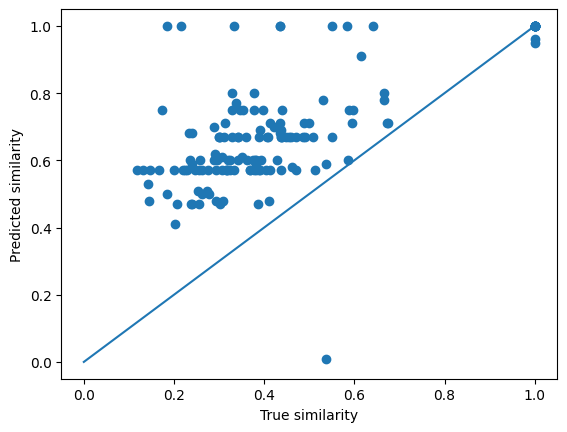

In [114]:
plt.figure()
plt.scatter(truths, predictions)
plt.plot([0,1], [0,1])
plt.xlabel("True similarity")
plt.ylabel("Predicted similarity")

In [115]:
from sklearn import metrics

In [117]:
metrics.mean_absolute_error(truths, predictions)

0.2588050414299281

In [119]:
from scipy.stats import spearmanr

In [120]:
spearmanr(truths, predictions)

SignificanceResult(statistic=0.5921268563599148, pvalue=6.762939816683644e-15)

# Solubility

In [173]:
soldf = pd.read_csv('Solubility.csv')

In [174]:
in_the_end = "[ug/mL] (The mean of the results at pH 7.4)"
filtered_rows = soldf[soldf['Property_Value'].str.contains(in_the_end, na=False, regex=False)]

In [177]:
len(filtered_rows) #[filtered_rows['validation']==1]

57859

In [178]:
filtered_rows

,index,CID,SMILES,Property_ID,Property_Name,Property_Value,validation
7,7,6,C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])Cl,3,Solubility,13.8 [ug/mL] (The mean of the results at pH 7.4),0
71,71,109,C(C(C(=O)O)N)S(=O)O,3,Solubility,>23 [ug/mL] (The mean of the results at pH 7.4),0
76,76,119,C(CC(=O)O)CN,3,Solubility,1.2 [ug/mL] (The mean of the results at pH 7.4),0
93,93,137,C(CC(=O)O)C(=O)CN,3,Solubility,18.6 [ug/mL] (The mean of the results at pH 7.4),0
145,145,190,C1=NC2=NC=NC(=C2N1)N,3,Solubility,>20.3 [ug/mL] (The mean of the results at pH 7.4),0
...,...,...,...,...,...,...,...
91949,91949,135856003,CC1C(=O)N/C(=N\N=C\C2=CC(=CC=C2)[N+](=O)[O-])/S1,3,Solubility,<0.1 [ug/mL] (The mean of the results at pH 7.4),0
91950,91950,135867650,C1=CC=C(C=C1)NC(=O)NC(=O)C[N+]2=CC=C(C=C2)/C=N/O,3,Solubility,41.6 [ug/mL] (The mean of the results at pH 7.4),0
91951,91951,135870906,CCOC(=O)C1=C(NC(=C1C)C(=NNC(=O)CN2C(=CC(=N2)C)...,3,Solubility,15.3 [ug/mL] (The mean of the results at pH 7.4),0
91955,91955,135877406,CC(C(=O)N1CCOCC1)SC2=NC(=CC(=O)N2)N,3,Solubility,>42.6 [ug/mL] (The mean of the results at pH 7.4),0


In [192]:
truths = []
predictions = []

for smiles, sol in tqdm(zip(filtered_rows['SMILES'], filtered_rows['Property_Value'])):
    try:
        truth = float(sol.split(' ')[0])
    except:
        continue
    # print(smiles, sol)
    prompt = f'</s>[START_SMILES]{smiles}[END_SMILES][PROPERTY]Solubility '
    # print(prompt + '\n')
    inputs = tokenizer(prompt, return_tensors="pt").input_ids
    inputs = inputs.to(device)
    # print(inputs.shape, prompt)
    
    # Generate outputs for the entire batch
    out = model.generate(inputs, max_new_tokens=20, do_sample=False, eos_token_id=20, return_dict_in_generate=True, output_scores=True)
    # out = model.generate(inputs, max_new_tokens=20, do_sample=False,
    #                             num_return_sequences=6, num_beams=6, length_penalty=-9, renormalize_logits=True,
    #                             repetition_penalty=1.0, diversity_penalty=1., num_beam_groups=3, 
    #                             eos_token_id=20, return_dict_in_generate=True, output_scores=True)
    for seq in out.sequences:
        decoded = tokenizer.decode(seq)
        print(decoded)
        try:
            predicted = decoded[len(prompt):decoded.find('[/PROPERTY]')]
            parts = predicted.split()
            if parts[1] != 'mg/L':
                continue
            predicted = float(parts[0])
            truths.append(truth)
            predictions.append(predicted)
        except:
            print("Skipping")
            print(prompt)
            print(decoded)
    # print(' ')

0it [00:00, ?it/s]

</s>[START_SMILES]C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])Cl[END_SMILES][PROPERTY]Solubility 1.75 mg/L @ 25 °C (est)[/PROPERTY][PROPERTY]Physical
</s>[START_SMILES]C(CC(=O)O)CN[END_SMILES][PROPERTY]Solubility 1.003, 1000000000000
</s>[START_SMILES]C(CC(=O)O)C(=O)CN[END_SMILES][PROPERTY]Solubility 1.000000000000000000
Skipping
</s>[START_SMILES]C(CC(=O)O)C(=O)CN[END_SMILES][PROPERTY]Solubility 
</s>[START_SMILES]C(CC(=O)O)C(=O)CN[END_SMILES][PROPERTY]Solubility 1.000000000000000000
</s>[START_SMILES]C(CCC(=O)O)CCN[END_SMILES][PROPERTY]Solubility 1.000000000000000000
Skipping
</s>[START_SMILES]C(CCC(=O)O)CCN[END_SMILES][PROPERTY]Solubility 
</s>[START_SMILES]C(CCC(=O)O)CCN[END_SMILES][PROPERTY]Solubility 1.000000000000000000
</s>[START_SMILES]C1=C(NC=N1)CCN[END_SMILES][PROPERTY]Solubility 1.000-000.000 0.06[/PROPERTY][PROPERTY]
</s>[START_SMILES]C1=CC(=CN=C1)C(=O)N[END_SMILES][PROPERTY]Solubility 0.294 mg/L @ 25 °C (est)[/PROPERTY][PROPERTY]
</s>[START_SMILES]CNCC(=O)O[END_SMILES][PROPERT

KeyboardInterrupt: 

(0.0, 3.0)

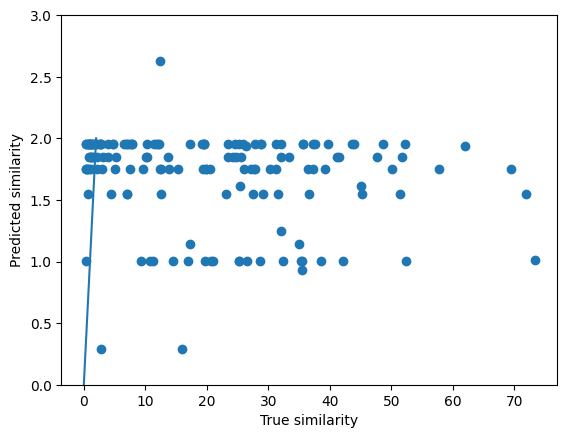

In [195]:
plt.figure()
plt.scatter(truths, predictions)
plt.plot([0,2], [0,2])
plt.xlabel("True similarity")
plt.ylabel("Predicted similarity")
plt.ylim(0, 3)